## Acquire images

This notebook will:

* Section 1: For a given bounding box and year, find all SAR images in that region. Get some stats on them
* Section 2: Filter out images from scenes that don't have sufficient preceding winter imagery for melt detection
* Section 3: Run ASF Hyp3 RTC processing
* Section 4: Download the data. Reproject it immedately and save only the smaller image. Does that work? I thought I would have to have EPSG vals? This will have to get figured out

### Preamble
Prepare to do stuff

In [2]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX

#capture
from datetime import datetime
import glob
import json # for loads
import os
from pathlib import Path
import pytz
import re
import shutil
import asf_search as asf
from zipfile import ZipFile
import time
import fnmatch

from matplotlib import pyplot as plt
#Writing Support Functions:

import numpy as np
from osgeo import gdal,osr

from IPython.display import HTML, display, clear_output, Markdown
    
from hyp3_sdk import Batch, HyP3

import opensarlab_lib as asfn

URLWidget()

In [58]:
##NAME PROJECT###
projdir = Path.home()/"GlacierSARdata"
projname = 'Denali_h'
year = 2019
data_dir=Path(f'{projdir}/{projname}/{str(year)}')
pols = ['VV','VH']

# Setting Paths
analysis_directory = Path.cwd()/data_dir
print(f"analysis_directory: {analysis_directory}")

download_path = analysis_directory/"rtc_download"
# download_path.mkdir()
products_path = analysis_directory/"rtc_products"
# products_path.mkdir()
clipped_path = analysis_directory/"rtc_clipped"

print(download_path)
print(products_path)
print(clipped_path)

os.makedirs(data_dir,exist_ok=True)
os.makedirs(download_path,exist_ok=True)
os.makedirs(products_path,exist_ok=True)
os.makedirs(analysis_directory/"figures",exist_ok=True)
os.makedirs(clipped_path,exist_ok=True)
for pol in pols:
    os.makedirs(clipped_path/pol,exist_ok=True)

# print(os.path.exists(data_dir))

WTKstr = None
if projname=="Wrangell": WTKstr='POLYGON((-144.5124 61.8108,-143.2512 61.8108,-143.2512 62.1938,-144.5124 62.1938,-144.5124 61.8108))' #Mt Wrangell
if projname=="Denali_h": WTKstr='POLYGON((-151.6946 62.7583,-150.1696 62.7583,-150.1696 63.2668,-151.6946 63.2668,-151.6946 62.7583))' #Denali_h (mostly higher elevations)
if projname=="Harding": WTKstr='POLYGON((-150.6448 59.6467,-149.5491 59.6467,-149.5491 60.2703,-150.6448 60.2703,-150.6448 59.6467))' #Harding
if projname=="Juneau": WTKstr='POLYGON((-134.7796 58.3698,-133.5 58.3698,-133.5 59.109,-134.7796 59.109,-134.7796 58.3698))' #Juneau

analysis_directory: /home/jovyan/GlacierSARdata/Denali_h/2019
/home/jovyan/GlacierSARdata/Denali_h/2019/rtc_download
/home/jovyan/GlacierSARdata/Denali_h/2019/rtc_products
/home/jovyan/GlacierSARdata/Denali_h/2019/rtc_clipped


In [3]:
# def timediff(time1,time2,form='seconds'):
#     '''time difference between time2 and time1 expressed as either days or seconds'''
#     # dd = 1
#     # if time1>time2:
#     #     dd=1
#     diff = time2-time1
#     if form=='seconds':
#         diff = diff.seconds+diff.days*86400
#     elif form=='days':
#         diff = diff.seconds/86400+diff.days
#     return diff

## Find SAR Images

Find the SAR images, run some statistics on their frequency, and queue them for Hyp3 processing

* stuff
* other stuff

In [17]:
# WTKstr = None
# if projname=="Wrangell": WTKstr='POLYGON((-144.5124 61.8108,-143.2512 61.8108,-143.2512 62.1938,-144.5124 62.1938,-144.5124 61.8108))' #Mt Wrangell
# if projname=="Denali_h": WTKstr='POLYGON((-151.6946 62.7583,-150.1696 62.7583,-150.1696 63.2668,-151.6946 63.2668,-151.6946 62.7583))' #Denali_h (mostly higher elevations)
# if projname=="Harding": WTKstr='POLYGON((-150.6448 59.6467,-149.5491 59.6467,-149.5491 60.2703,-150.6448 60.2703,-150.6448 59.6467))' #Harding
# if projname=="Juneau": WTKstr='POLYGON((-134.7796 58.3698,-133.5 58.3698,-133.5 59.109,-134.7796 59.109,-134.7796 58.3698))' #Juneau

#testpolygon = POLYGON((-143.1356 61.7756,-143.3698 61.7793,-143.5279 61.7044,-143.3824 61.6052,-143.0614 61.4737,-142.9854 61.4144,-142.804 61.4292,-142.7358 61.5912,-142.5978 61.6494,-142.6707 61.7523,-142.9699 61.7839,-143.1356 61.7756))
# WTKstr='POLYGON((-143.4858 61.4239,-142.5307 61.4239,-142.5307 61.7757,-143.4858 61.7757,-143.4858 61.4239))' #Kennicott
# testWTK='POLYGON((-134.5463 58.5889,-133.8663 58.5889,-133.8663 58.7656,-134.5463 58.7656,-134.5463 58.5889))' #SE AK icefield
# testWTK='POLYGON((-18.2664 63.9706,-15.2442 63.9706,-15.2442 64.9461,-18.2664 64.9461,-18.2664 63.9706))' #iceland
# testWTK='POLYGON((15.123 78.0197,16.9688 78.0197,16.9688 78.2449,15.123 78.2449,15.123 78.0197))' #svalbard
# testWTK = 'POLYGON((-140.264 60.3786,-140.0853 60.3786,-140.0853 60.4539,-140.264 60.4539,-140.264 60.3786))'
# testWTK='POLYGON((-50.0733 70.6347,-47.6859 70.6347,-47.6859 71.1109,-50.0733 71.1109,-50.0733 70.6347))' #west greenland

In [59]:
#funcs for this kind of thing:

def timediff(time1,time2,form='seconds'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

def getasfresults(WTKstr,year,trimresults=True,winterN=4,showplots=False,showstats=False):
    """trim results removes images if there are less than winterN number of winter scenes to establish the baseline"""
    results = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1], intersectsWith=WTKstr, maxResults=1000,start=f'{str(year)}-01-01',
                         end=f'{str(year+1)}-01-01',processingLevel='SLC')

    datelist = []
    pflist = [] #path-frame list
    for res in results:
        res = res.properties
        # print(res['startTime'])
        rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%fZ')
        rpf = str(res['pathNumber'])+'-'+str(res['frameNumber'])
        # print(rdate)
        res['datetime']=rdate
        res['pfval'] = rpf
        datelist.append(rdate)
        pflist.append(rpf)


    pfunique = np.unique(pflist)
    pfvals = pflist
    pflist = [np.where(pfunique==i)[0][0] for i in pflist]
    
    if showplots==True:
        plt.figure()
        plt.plot(datelist,pflist,'.',markersize=12)
        
    if trimresults==True:
        wstart = datetime(year,1,1,0,0,0)
        wend = datetime(year,4,1,1,0,0,0)
        #result2 = results
        pfremove=[]
        trem = 0
        #identify path-frames that do not meet requirements
        for pf in pfunique:
            eles = [i for i in results if i.properties['pfval']==pf]
            datelist = np.array([i.properties['datetime'] for i in eles])
            dl2 = datelist[datelist > wstart]
            dl2 = dl2[dl2 < wend]
            if len(dl2)<winterN:
                pfremove.append(pf)
                trem += len(datelist)

        #remove images from those path-frames
        for res in results:
            if res.properties['pfval'] in pfremove:
                results.remove(res)

        print(f'total removed: {trem}')
        # print(pfremove)
        
        #now plot again:
        datelist = [i.properties['datetime'] for i in results]
        pflist = [i.properties['pfval'] for i in results]
        pfunique = np.unique(pflist)
        pflist = [np.where(pfunique==i)[0][0] for i in pflist]

        if showplots==True:
            plt.figure()
            plt.plot(datelist,pflist,'.',markersize=12)
        
    if showstats==True:
        dlsort = [i for i in datelist]
        dlsort.sort()
        dldelta = [timediff(dlsort[i],dlsort[i+1],form='days') for i in range(len(dlsort)-1)]
        dldelta = np.array(dldelta)

        print('Acquisition stats')
        print(f'Number of acquisitions:       {len(dldelta)+1}')
        print(f'Number of images >1min apart: {len(dldelta[dldelta>1/1440])+1}\n')
        print(f'Mean days apart:   {np.mean(dldelta):.3f}')
        print(f'Mean days >1min:   {np.mean(dldelta[dldelta>1/1440]):.3f}')
        print(f'Median days apart: {np.median(dldelta):.3f}')
        print(f'Median days >1min: {np.median(dldelta[dldelta>1/1440]):.3f}')
        print(f'Stdev days apart:  {np.std(dldelta):.3f}')
        print(f'Longest gap:       {np.max(dldelta):.3f}')
        print('Note: these are over the whole area, not necessarily by pixel')
        
    return results

## Do Hyp3 Processing

I need to:

1. Identify all the images you want DONE
2. Check if any of those are already RTC processed (not expired)
3. Process all the remaining jobs
4. Make a hyp3 object for the full list of jobs, with those done via new process and those done via old process
5. download, extract, convert, and clip from those jobs

In [5]:
hyp3 = HyP3(prompt=True)

NASA Earthdata Login username:  acjohnson16
NASA Earthdata Login password:  ·········


Denali_h: 2019
total removed: 14
Acquisition stats
Number of acquisitions:       30
Number of images >1min apart: 30

Mean days apart:   12.000
Mean days >1min:   12.000
Median days apart: 12.000
Median days >1min: 12.000
Stdev days apart:  0.000
Longest gap:       12.000
Note: these are over the whole area, not necessarily by pixel
total removed: 14
jobs already ready: 30
Number of jobs to do: 0


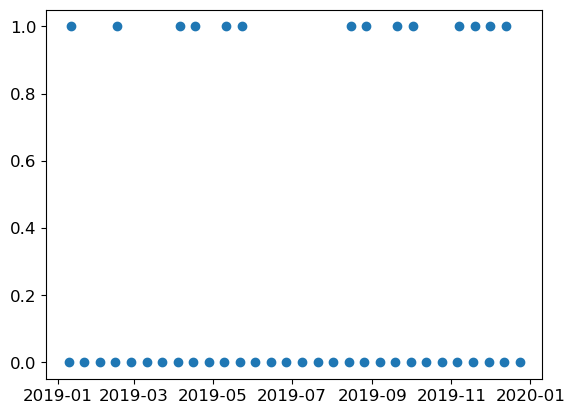

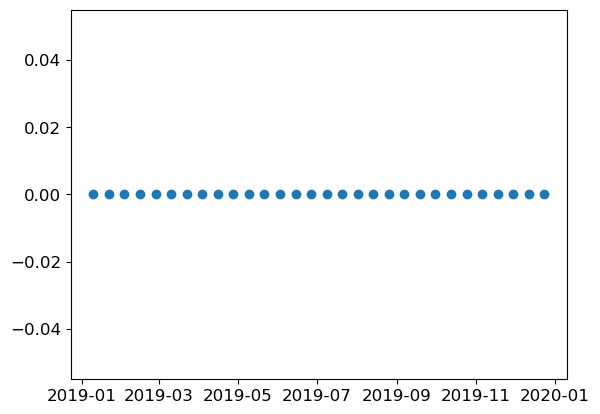

In [60]:
#Get_Data

print(f'{projname}: {year}')
readyproducts = hyp3.find_jobs()
readyproducts = readyproducts.filter_jobs(succeeded=True,include_expired=False)
readyprodnames = [i.job_parameters['granules'][0] for i in readyproducts]

results = getasfresults(WTKstr,year,showplots=True,showstats=True)
dojobs = getasfresults(WTKstr,year)
resultnames = [i.properties['sceneName'] for i in results]

remcount = 0
for i,job in enumerate(results):
    jobscene = job.properties['sceneName']
    dojobnames = np.array([i.properties['sceneName'] for i in dojobs])
    job = dojobs[np.where(dojobnames==jobscene)[0][0]]
    # othercount += 1
    if job.properties['sceneName'] in readyprodnames:
        # print(i)
        dojobs.remove(job)
        remcount += 1
        

print(f'jobs already ready: {remcount}')
print(f'Number of jobs to do: {len(dojobs)}')

In [43]:
#Submit jobs for RTC processing

projectname = f'{projname}_{year%1000}'

granules = [i.properties['sceneName'] for i in dojobs]

submitjobs = True
if submitjobs:
    rtc_jobs = Batch()
    for g in granules:
        rtc_jobs += hyp3.submit_rtc_job(g, name=projectname)
    print(rtc_jobs)
else:
    print("Note: no job submitted as submitjobs is currently 'False'")
print(hyp3.my_info()['quota'])

51 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 51 pending.
{'max_jobs_per_month': 1000, 'remaining': 735}


In [16]:
#do failed jobs if necessary (set to True)

dofailedjob = False
if dofailedjob:
    hyp3.submit_rtc_job('S1A_IW_SLC__1SDV_20210701T155634_20210701T155701_038586_048D97_C318', name = projectname)

In [7]:
print(hyp3.my_info()['quota'])

{'max_jobs_per_month': 1000, 'remaining': 1000}


## Utility Functions

download images\
extract images\
reproject and clip to wtk\
convert to db\
do this sequentially

In [7]:
#convert utility
def converttodb(file):
    ds = gdal.Open(file, gdal.GA_Update)
    data = ds.ReadAsArray()

    data[data<1e-6]=1e-6
    
    data = 10*np.log10(data)
    data[data==-np.inf]=-60
    ds.GetRasterBand(1).WriteArray(data)
    ds = None

#download utility:
def extracttif(inloc,outloc,pol='VV',convert=True):
    """expect pol to be 'VV','VH','HH', or 'HV' 
    convert will convert this to db"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infile = glob.glob(f'{inloc}*')
    endstr = pol+'.tif'
    for file in infile:
        # print(file)
        # namelist = 
        with ZipFile(file) as z:
            # print(z.namelist)
            z = ZipFile(file)
            zname = [name for name in z.namelist() if name[-6:]==endstr]
            if len(zname)>0:
                zname = zname[0]
        
                filename = os.path.basename(zname)
                source = z.open(zname)
                targetname = os.path.join(outloc, filename)
                target = open(targetname, "wb")
                with source, target:
                    shutil.copyfileobj(source, target)
                target.close()
                if convert:
                    converttodb(targetname)
        # os.remove(file)
        

In [8]:
#CLIPPING TOOLS

def wtkparse(wtk):
    """It's not weird if it works"""
    wtk = wtk.split("'")
    wtk = wtk[0].split("(")[2]
    wtk = wtk.split(")")[0]
    wtk = wtk.split(',')
    wtk = [s.split(' ') for s in wtk]
    wtk = np.array([[float(ss) for ss in s] for s in wtk])
    return(wtk)

def CoordConvert(points,inproj,outproj,ptparse=False):
    """Convert coordinate grid from one projection to another
    if converting from 4326, then points should be ordered lon,lat"""

    if ptparse:
        points = wtkparse(points)

    if type(inproj)==str:
        inproj=int(inproj)
    if type(outproj)==str:
        outproj=int(outproj)

    epsgin = osr.SpatialReference()
    epsgin.ImportFromEPSG(inproj)   
    epsgout = osr.SpatialReference()
    epsgout.ImportFromEPSG(outproj)

    convert = osr.CoordinateTransformation(epsgin, epsgout)
    points = np.array(points)
    
    for i,x in enumerate(points):
        newpt = convert.TransformPoint(x[1],x[0])
        points[i,0],points[i,1]=newpt[0],newpt[1]
        
    return points

def wtktobox(wtk,epsgn,srcproj = 4326):
    """epsgn is the epsg of the tif file
    output will be ulx uly lrx lry"""
    epsgn = int(epsgn)
    srcproj = int(srcproj)
    xyp = CoordConvert(wtk,4326,epsgn,ptparse=True)
    ulx,uly = np.min(xyp[:,0]),np.max(xyp[:,1])
    lrx,lry = np.max(xyp[:,0]),np.min(xyp[:,1])
    return ulx,uly,lrx,lry

def testEPSG(inloc):
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    # if str(outloc)[-1]!='/':
        # outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    for file in infiles:
        ds=gdal.Open(file)
        proj = osr.SpatialReference(wkt=ds.GetProjection())
        dsproj = proj.GetAttrValue('AUTHORITY',1)
        ds = None
        print(dsproj)
# testEPSG(products_path)

def getEPSG(file):
    ds=gdal.Open(file)
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    dsproj = proj.GetAttrValue('AUTHORITY',1)
    ds = None
    return dsproj

def identify_epsgs(fileloc):
    """Identify EPSG systems used in this. By default this will return the most commonly one."""
    if str(fileloc)[-1]!='/':
        fileloc = str(fileloc)+'/'
    filelist = glob.glob(f'{fileloc}*')
    eplist = []
    for file in filelist:
        eplist.append(getEPSG(file))
        # print(eplist[-1])
        # print(file)
    epu,epc = np.unique(eplist,return_counts=True)
    for i,ep in enumerate(epu):
        count = epc[i]
        print(f'Found EPSG:{ep}, count: {count}')
    return epu[np.where(epc==np.max(epc))[0]][0]

def reproject(wtk,epsgn,inloc,outloc,res=30,convert_to_db=False):
    """make the magic happen"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    
    epsgn = int(epsgn)
    ulx,uly,lrx,lry = wtktobox(wtk,epsgn)
    # c1=0
    epsgns = f'ESPG:{str(epsgn)}'
    for file in infiles:
        ofile = file.replace(inloc,outloc)
        # ofile = '/home/jovyan/test/rtc_clipped/S1B_IW_20210713T031944_DVP_RTC30_G_gpuned_1E76_VV'
        epsgf = int(getEPSG(file))
        epsgfs = f'ESPG:{str(epsgf)}'
        src = gdal.Open(file)
        # print(ofile)
        # print(type(ofile))
        
        epsgo = osr.SpatialReference()
        epsgo.ImportFromEPSG(epsgn)   
        
        gdal.Warp(destNameOrDestDS=ofile,srcDSOrSrcDSTab=src,dstSRS=epsgo,
                  outputBounds=(ulx,lry,lrx,uly),outputBoundsSRS=epsgo,resampleAlg='near',
                  xRes=res,yRes=res)
        
        if convert_to_db:
            converttodb(ofile)

## Get Data

In [9]:
#Download the products, unzip them into the rtc_download directory, convert them to dB, and delete the zip files:

# EPSGn = '32607'
pols = ['VV','VH']

autoEPSG=True #use this to pull the first projection and use that as your projection for all images

# First check if jobs are running
class Error(Exception):
    """Base class for other exceptions"""
    pass
class stillrunningError(Error):
    """raised when jobs are still running"""
    pass

running = len(hyp3.find_jobs(status_code=["RUNNING"]))
running += len(hyp3.find_jobs(status_code=["PENDING"]))

if running > 0:
    print('Jobs still running!')
    raise stillrunningError
else:
    print('No jobs running, all clear')

No jobs running, all clear


In [8]:
# Get the list of jobs to download
usegranules = [i.properties['sceneName'] for i in results]
joblist = hyp3.find_jobs()
joblist = joblist.filter_jobs(succeeded=True,include_expired=False)
joblen = len(results)-1

t = time.time()
count = 0
for i,job in enumerate(joblist):

    jobname = job.job_parameters['granules'][0]

    if jobname in usegranules:
        count += 1
        usegranules.remove(jobname)
        if count%10 ==0:
            te = time.time()-t
            print(f'Current job: {count}/{joblen}, time elapsed: {te/60:.2f} min, time remaining: {(te/(i+1)*(joblen-count))/60:.2f} min')
        # job.download_files(download_path)
        # for pol in pols:
            # print(pol)
            # extracttif(download_path,products_path,pol=pol,convert=False)
            # if autoEPSG:
                # if (count == 1) and (pol == pols[0]):
                    # fileg = glob.glob(f'{str(products_path)}/*.tif')
                    # EPSGn = getEPSG(fileg[0])
                    # print(getEPSG(fileg[0]))
            # fulltif = glob.glob(f'{str(products_path)}/*{pol}*')
            # reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
            # os.system(f'rm {str(products_path)}/*.tif')
            # time.sleep(3)
        # os.system(f'rm {str(download_path)}/*.zip')
        print(f"{i}: {jobname}")
print(count)
if len(usegranules)>0:
    print('WARNING: NOT ALL GRANULES USED')

156: S1B_IW_SLC__1SSV_20170103T161137_20170103T161204_003686_00653D_DC77
157: S1B_IW_SLC__1SDV_20170113T030256_20170113T030323_003824_006932_78C2
158: S1B_IW_SLC__1SDV_20170111T031914_20170111T031942_003795_00685F_7C8B
159: S1B_IW_SLC__1SSV_20170117T155522_20170117T155549_003890_006B27_8927
160: S1B_IW_SLC__1SSV_20170124T154703_20170124T154730_003992_006E3A_80C3
161: S1B_IW_SLC__1SSV_20170127T161137_20170127T161204_004036_006F95_AE91
162: S1B_IW_SLC__1SDV_20170206T030255_20170206T030322_004174_007398_7474
163: S1B_IW_SLC__1SDV_20170204T031913_20170204T031941_004145_0072BE_6035
164: S1B_IW_SLC__1SSV_20170210T155521_20170210T155548_004240_00759A_8621
Current job: 10/108, time elapsed: 0.00 min, time remaining: 0.00 min
165: S1B_IW_SLC__1SSV_20170217T154703_20170217T154730_004342_0078AB_A6A8
166: S1B_IW_SLC__1SSV_20170220T161136_20170220T161203_004386_007A0B_DF36
167: S1B_IW_SLC__1SSV_20170222T155521_20170222T155548_004415_007AE7_5F89
168: S1B_IW_SLC__1SDV_20170228T031913_20170228T031941_

In [85]:
usegranules = [i.properties['sceneName'] for i in results]
# joblist = hyp3.find_jobs()
# joblist = joblist.filter_jobs(succeeded=True,include_expired=False)
# joblen = len(results)-1

#NOTE: a result that is listed by has no file is: 1201T...22
#      a file that exists by has no result is:    

job = joblist[-11]
jobname = job.job_parameters['granules']
print(jobname)
# job.download_files(download_path)
# reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
# os.system(f'rm {str(products_path)}/*.tif')
# os.system(f'rm {str(download_path)}/*.zip')
for i,job in enumerate(joblist):
    print(f'{i}: {job.job_parameters["granules"][0]}')

['S1B_IW_SLC__1SDV_20171203T030304_20171203T030331_008549_00F2AE_DE90']
0: S1B_IW_SLC__1SSV_20170101T162824_20170101T162901_003657_006459_DCFF
1: S1B_IW_SLC__1SSV_20170103T161202_20170103T161230_003686_00653D_E5A4
2: S1B_IW_SLC__1SSV_20170103T161228_20170103T161256_003686_00653D_BACD
3: S1B_IW_SLC__1SSV_20170125T162823_20170125T162900_004007_006EB3_A47A
4: S1B_IW_SLC__1SSV_20170127T161202_20170127T161229_004036_006F95_CAFC
5: S1B_IW_SLC__1SSV_20170127T161227_20170127T161255_004036_006F95_EFFE
6: S1B_IW_SLC__1SSV_20170218T162823_20170218T162900_004357_007925_1CB7
7: S1B_IW_SLC__1SSV_20170220T161201_20170220T161228_004386_007A0B_760E
8: S1B_IW_SLC__1SSV_20170220T161226_20170220T161255_004386_007A0B_9CB5
9: S1B_IW_SLC__1SSV_20170304T161201_20170304T161229_004561_007F26_19EF
10: S1B_IW_SLC__1SSV_20170314T162823_20170314T162900_004707_008371_4FCA
11: S1B_IW_SLC__1SSV_20170304T161227_20170304T161255_004561_007F26_2E55
12: S1B_IW_SLC__1SSV_20170316T161201_20170316T161229_004736_008452_BE3C
13

In [26]:
# Get the list of jobs to download
usegranules = [i.properties['sceneName'] for i in results]
joblist = hyp3.find_jobs()
joblist = joblist.filter_jobs(succeeded=True,include_expired=False)
joblen = len(results)-1

t = time.time()
count = 0
for i,job in enumerate(joblist):

    jobname = job.job_parameters['granules'][0]

    if jobname in usegranules:
        count += 1
        usegranules.remove(jobname)
        if count%10 ==0:
            te = time.time()-t
            print(f'Current job: {count}/{joblen}, time elapsed: {te/60:.2f} min, time remaining: {(te/(i+1)*(joblen-count))/60:.2f} min')
        job.download_files(download_path)
        for pol in pols:
            # print(pol)
            extracttif(download_path,products_path,pol=pol,convert=False)
            if autoEPSG:
                if (count == 1) and (pol == pols[0]):
                    fileg = glob.glob(f'{str(products_path)}/*.tif')
                    EPSGn = getEPSG(fileg[0])
                    print(getEPSG(fileg[0]))
            # fulltif = glob.glob(f'{str(products_path)}/*{pol}*')
            reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
            os.system(f'rm {str(products_path)}/*.tif')
            time.sleep(3)
        os.system(f'rm {str(download_path)}/*.zip')
        
if len(usegranules)>0:
    print('WARNING: NOT ALL GRANULES USED')

S1B_IW_20170103T161137_SVP_RTC30_G_gpuned_1404.zip:   0%|          | 0/223438636 [00:00<?, ?it/s]

32606


rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170113T030256_DVP_RTC30_G_gpuned_A161.zip:   0%|          | 0/450185437 [00:00<?, ?it/s]

S1B_IW_20170111T031914_DVP_RTC30_G_gpuned_FF1C.zip:   0%|          | 0/468905528 [00:00<?, ?it/s]

S1B_IW_20170117T155522_SVP_RTC30_G_gpuned_5F65.zip:   0%|          | 0/224995070 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170124T154703_SVP_RTC30_G_gpuned_F2E4.zip:   0%|          | 0/224949853 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170127T161137_SVP_RTC30_G_gpuned_10EF.zip:   0%|          | 0/222936908 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170206T030255_DVP_RTC30_G_gpuned_333E.zip:   0%|          | 0/449550481 [00:00<?, ?it/s]

S1B_IW_20170204T031913_DVP_RTC30_G_gpuned_1072.zip:   0%|          | 0/468021191 [00:00<?, ?it/s]

S1B_IW_20170210T155521_SVP_RTC30_G_gpuned_5562.zip:   0%|          | 0/225106982 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


Current job: 10/108, time elapsed: 2.48 min, time remaining: 1.46 min


S1B_IW_20170217T154703_SVP_RTC30_G_gpuned_3667.zip:   0%|          | 0/224766051 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170220T161136_SVP_RTC30_G_gpuned_A01D.zip:   0%|          | 0/223228523 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170222T155521_SVP_RTC30_G_gpuned_4C5E.zip:   0%|          | 0/225159809 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170228T031913_DVP_RTC30_G_gpuned_9F15.zip:   0%|          | 0/467773371 [00:00<?, ?it/s]

S1B_IW_20170301T154703_SVP_RTC30_G_gpuned_12C6.zip:   0%|          | 0/225083666 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170302T030255_DVP_RTC30_G_gpuned_47A3.zip:   0%|          | 0/449363055 [00:00<?, ?it/s]

S1B_IW_20170304T161136_SVP_RTC30_G_gpuned_2224.zip:   0%|          | 0/223349686 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170306T155521_SVP_RTC30_G_gpuned_1FE3.zip:   0%|          | 0/225208157 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170312T031913_DVP_RTC30_G_gpuned_FA02.zip:   0%|          | 0/467880217 [00:00<?, ?it/s]

S1B_IW_20170313T154703_SVP_RTC30_G_gpuned_14BF.zip:   0%|          | 0/224803475 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


Current job: 20/108, time elapsed: 5.07 min, time remaining: 2.54 min


S1B_IW_20170314T030255_DVP_RTC30_G_gpuned_201D.zip:   0%|          | 0/449150915 [00:00<?, ?it/s]

S1B_IW_20170316T161136_SVP_RTC30_G_gpuned_A71E.zip:   0%|          | 0/223182665 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170324T031913_DVP_RTC30_G_gpuned_AF29.zip:   0%|          | 0/467597700 [00:00<?, ?it/s]

S1B_IW_20170326T030255_DVP_RTC30_G_gpuned_1ED6.zip:   0%|          | 0/448785287 [00:00<?, ?it/s]

S1B_IW_20170405T031914_DVP_RTC30_G_gpuned_1F31.zip:   0%|          | 0/469527508 [00:00<?, ?it/s]

S1B_IW_20170407T030256_DVP_RTC30_G_gpuned_633E.zip:   0%|          | 0/452463677 [00:00<?, ?it/s]

S1B_IW_20170417T031914_DVP_RTC30_G_gpuned_47E7.zip:   0%|          | 0/469287838 [00:00<?, ?it/s]

S1B_IW_20170429T031915_DVP_RTC30_G_gpuned_0216.zip:   0%|          | 0/471674516 [00:00<?, ?it/s]

S1B_IW_20170419T030256_DVP_RTC30_G_gpuned_C8FC.zip:   0%|          | 0/450760359 [00:00<?, ?it/s]

S1B_IW_20170501T030257_DVP_RTC30_G_gpuned_BCA5.zip:   0%|          | 0/451221272 [00:00<?, ?it/s]

Current job: 30/108, time elapsed: 8.47 min, time remaining: 3.55 min


S1A_IW_20170511T155606_SVP_RTC30_G_gpuned_90A5.zip:   0%|          | 0/225355870 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170511T031915_DVP_RTC30_G_gpuned_7C20.zip:   0%|          | 0/471929660 [00:00<?, ?it/s]

S1B_IW_20170513T030257_DVP_RTC30_G_gpuned_66C0.zip:   0%|          | 0/451672086 [00:00<?, ?it/s]

S1A_IW_20170518T154748_SVP_RTC30_G_gpuned_7A1D.zip:   0%|          | 0/225691065 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170523T031916_DVP_RTC30_G_gpuned_2078.zip:   0%|          | 0/471904581 [00:00<?, ?it/s]

S1A_IW_20170523T155606_SVP_RTC30_G_gpuned_2A7B.zip:   0%|          | 0/225528141 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1A_IW_20170530T154748_SVP_RTC30_G_gpuned_71A3.zip:   0%|          | 0/226052072 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1A_IW_20170602T161222_SVP_RTC30_G_gpuned_061F.zip:   0%|          | 0/192091133 [00:00<?, ?it/s]

rm: cannot remove '/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_products/*.tif': No such file or directory


S1B_IW_20170604T031917_DVP_RTC30_G_gpuned_6F23.zip:   0%|          | 0/470925288 [00:00<?, ?it/s]

S1A_IW_20170604T155607_DVP_RTC30_G_gpuned_58F3.zip:   0%|          | 0/454453371 [00:00<?, ?it/s]

Current job: 40/108, time elapsed: 11.48 min, time remaining: 3.98 min


S1B_IW_20170606T030259_DVP_RTC30_G_gpuned_6E1B.zip:   0%|          | 0/451279355 [00:00<?, ?it/s]

S1A_IW_20170614T161223_DVP_RTC30_G_gpuned_549B.zip:   0%|          | 0/385925613 [00:00<?, ?it/s]

S1A_IW_20170611T154749_DVP_RTC30_G_gpuned_C8C3.zip:   0%|          | 0/454077508 [00:00<?, ?it/s]

S1A_IW_20170616T155608_DVP_RTC30_G_gpuned_69D1.zip:   0%|          | 0/453424111 [00:00<?, ?it/s]

S1B_IW_20170616T031917_DVP_RTC30_G_gpuned_C2AE.zip:   0%|          | 0/470643047 [00:00<?, ?it/s]

S1B_IW_20170618T030300_DVP_RTC30_G_gpuned_7AC0.zip:   0%|          | 0/450565258 [00:00<?, ?it/s]

S1A_IW_20170623T154750_DVP_RTC30_G_gpuned_4D4B.zip:   0%|          | 0/456131314 [00:00<?, ?it/s]

S1B_IW_20170628T031918_DVP_RTC30_G_gpuned_B841.zip:   0%|          | 0/470021432 [00:00<?, ?it/s]

S1A_IW_20170628T155608_DVP_RTC30_G_gpuned_A4DC.zip:   0%|          | 0/452708545 [00:00<?, ?it/s]

S1B_IW_20170630T030300_DVP_RTC30_G_gpuned_0C97.zip:   0%|          | 0/450795736 [00:00<?, ?it/s]

Current job: 50/108, time elapsed: 14.85 min, time remaining: 4.18 min


S1A_IW_20170705T154750_DVP_RTC30_G_gpuned_D2F8.zip:   0%|          | 0/455443703 [00:00<?, ?it/s]

S1B_IW_20170710T031919_DVP_RTC30_G_gpuned_21A2.zip:   0%|          | 0/469511668 [00:00<?, ?it/s]

S1A_IW_20170710T155609_DVP_RTC30_G_gpuned_94ED.zip:   0%|          | 0/452232767 [00:00<?, ?it/s]

S1A_IW_20170717T154751_DVP_RTC30_G_gpuned_0C52.zip:   0%|          | 0/455658033 [00:00<?, ?it/s]

S1B_IW_20170722T031920_DVP_RTC30_G_gpuned_B265.zip:   0%|          | 0/469237794 [00:00<?, ?it/s]

S1A_IW_20170722T155610_DVP_RTC30_G_gpuned_2AAC.zip:   0%|          | 0/452591748 [00:00<?, ?it/s]

S1A_IW_20170729T154752_DVP_RTC30_G_gpuned_59B5.zip:   0%|          | 0/454785140 [00:00<?, ?it/s]

S1A_IW_20170803T155610_DVP_RTC30_G_gpuned_06D5.zip:   0%|          | 0/452358852 [00:00<?, ?it/s]

S1B_IW_20170805T030302_DVP_RTC30_G_gpuned_C813.zip:   0%|          | 0/450387461 [00:00<?, ?it/s]

S1A_IW_20170810T154753_DVP_RTC30_G_gpuned_C989.zip:   0%|          | 0/454928558 [00:00<?, ?it/s]

Current job: 60/108, time elapsed: 18.26 min, time remaining: 4.06 min


S1A_IW_20170813T161226_DVP_RTC30_G_gpuned_38F0.zip:   0%|          | 0/384345794 [00:00<?, ?it/s]

S1B_IW_20170815T031921_DVP_RTC30_G_gpuned_5615.zip:   0%|          | 0/469635643 [00:00<?, ?it/s]

S1A_IW_20170815T155611_DVP_RTC30_G_gpuned_21CA.zip:   0%|          | 0/452651925 [00:00<?, ?it/s]

S1B_IW_20170817T030303_DVP_RTC30_G_gpuned_F103.zip:   0%|          | 0/450581299 [00:00<?, ?it/s]

S1A_IW_20170822T154753_DVP_RTC30_G_gpuned_EF38.zip:   0%|          | 0/454241013 [00:00<?, ?it/s]

S1B_IW_20170827T031921_DVP_RTC30_G_gpuned_E89F.zip:   0%|          | 0/469793715 [00:00<?, ?it/s]

S1A_IW_20170827T155612_DVP_RTC30_G_gpuned_A955.zip:   0%|          | 0/452124636 [00:00<?, ?it/s]

S1B_IW_20170829T030303_DVP_RTC30_G_gpuned_6FC5.zip:   0%|          | 0/450462719 [00:00<?, ?it/s]

S1A_IW_20170903T154754_DVP_RTC30_G_gpuned_8CFE.zip:   0%|          | 0/453657332 [00:00<?, ?it/s]

S1B_IW_20170908T031922_DVP_RTC30_G_gpuned_AAB7.zip:   0%|          | 0/469348396 [00:00<?, ?it/s]

Current job: 70/108, time elapsed: 21.80 min, time remaining: 3.67 min


S1A_IW_20170908T155612_DVP_RTC30_G_gpuned_8ACC.zip:   0%|          | 0/451626359 [00:00<?, ?it/s]

S1B_IW_20170910T030304_DVP_RTC30_G_gpuned_6F3A.zip:   0%|          | 0/450199499 [00:00<?, ?it/s]

S1A_IW_20170915T154754_DVP_RTC30_G_gpuned_2D8C.zip:   0%|          | 0/453896072 [00:00<?, ?it/s]

S1B_IW_20170920T031922_DVP_RTC30_G_gpuned_A4C9.zip:   0%|          | 0/469926575 [00:00<?, ?it/s]

S1A_IW_20170920T155613_DVP_RTC30_G_gpuned_01FE.zip:   0%|          | 0/452112984 [00:00<?, ?it/s]

S1B_IW_20170922T030304_DVP_RTC30_G_gpuned_5C07.zip:   0%|          | 0/450439727 [00:00<?, ?it/s]

S1A_IW_20170927T154754_DVP_RTC30_G_gpuned_A6DA.zip:   0%|          | 0/454666016 [00:00<?, ?it/s]

S1A_IW_20170930T161228_DVP_RTC30_G_gpuned_63E6.zip:   0%|          | 0/383247440 [00:00<?, ?it/s]

S1B_IW_20171002T031923_DVP_RTC30_G_gpuned_08EC.zip:   0%|          | 0/468807386 [00:00<?, ?it/s]

S1A_IW_20171002T155613_DVP_RTC30_G_gpuned_3133.zip:   0%|          | 0/451853994 [00:00<?, ?it/s]

Current job: 80/108, time elapsed: 25.32 min, time remaining: 3.00 min


S1A_IW_20171009T154755_DVP_RTC30_G_gpuned_1958.zip:   0%|          | 0/453353568 [00:00<?, ?it/s]

S1A_IW_20171012T161228_DVP_RTC30_G_gpuned_D75E.zip:   0%|          | 0/382632976 [00:00<?, ?it/s]

S1A_IW_20171014T155613_DVP_RTC30_G_gpuned_94AA.zip:   0%|          | 0/451973798 [00:00<?, ?it/s]

S1B_IW_20171016T030305_DVP_RTC30_G_gpuned_35EC.zip:   0%|          | 0/447505765 [00:00<?, ?it/s]

S1A_IW_20171021T154755_DVP_RTC30_G_gpuned_1D16.zip:   0%|          | 0/451744656 [00:00<?, ?it/s]

S1A_IW_20171026T155613_DVP_RTC30_G_gpuned_CBB1.zip:   0%|          | 0/452332372 [00:00<?, ?it/s]

S1A_IW_20171024T161228_DVP_RTC30_G_gpuned_FE04.zip:   0%|          | 0/382597520 [00:00<?, ?it/s]

S1B_IW_20171028T030305_DVP_RTC30_G_gpuned_7360.zip:   0%|          | 0/451083436 [00:00<?, ?it/s]

S1A_IW_20171102T154755_DVP_RTC30_G_gpuned_6B23.zip:   0%|          | 0/451973242 [00:00<?, ?it/s]

S1B_IW_20171107T031923_DVP_RTC30_G_gpuned_D7B7.zip:   0%|          | 0/466576212 [00:00<?, ?it/s]

Current job: 90/108, time elapsed: 28.74 min, time remaining: 2.10 min


S1B_IW_20171109T030305_DVP_RTC30_G_gpuned_2D1F.zip:   0%|          | 0/447948158 [00:00<?, ?it/s]

S1A_IW_20171107T155613_DVP_RTC30_G_gpuned_38F1.zip:   0%|          | 0/450791660 [00:00<?, ?it/s]

S1A_IW_20171114T154754_DVP_RTC30_G_gpuned_04B9.zip:   0%|          | 0/452316654 [00:00<?, ?it/s]

S1A_IW_20171117T161228_DVP_RTC30_G_gpuned_2685.zip:   0%|          | 0/383534991 [00:00<?, ?it/s]

S1A_IW_20171119T155613_DVP_RTC30_G_gpuned_4EB9.zip:   0%|          | 0/451315829 [00:00<?, ?it/s]

S1B_IW_20171121T030304_DVP_RTC30_G_gpuned_B33E.zip:   0%|          | 0/449505269 [00:00<?, ?it/s]

S1A_IW_20171126T154754_DVP_RTC30_G_gpuned_AD26.zip:   0%|          | 0/453955708 [00:00<?, ?it/s]

S1B_IW_20171201T031922_DVP_RTC30_G_gpuned_C38B.zip:   0%|          | 0/467339883 [00:00<?, ?it/s]

S1A_IW_20171129T161228_DVP_RTC30_G_gpuned_478A.zip:   0%|          | 0/383592760 [00:00<?, ?it/s]

S1A_IW_20171201T155612_DVP_RTC30_G_gpuned_005E.zip:   0%|          | 0/451281380 [00:00<?, ?it/s]

Current job: 100/108, time elapsed: 32.11 min, time remaining: 1.00 min


S1B_IW_20171203T030304_DVP_RTC30_G_gpuned_E5AF.zip:   0%|          | 0/448757410 [00:00<?, ?it/s]

S1A_IW_20171208T154754_DVP_RTC30_G_gpuned_5BD8.zip:   0%|          | 0/453812166 [00:00<?, ?it/s]

S1A_IW_20171211T161227_DVP_RTC30_G_gpuned_E257.zip:   0%|          | 0/385987604 [00:00<?, ?it/s]

S1B_IW_20171213T031922_DVP_RTC30_G_gpuned_49B7.zip:   0%|          | 0/468857392 [00:00<?, ?it/s]

S1A_IW_20171213T155612_DVP_RTC30_G_gpuned_E2FD.zip:   0%|          | 0/452509117 [00:00<?, ?it/s]

S1B_IW_20171215T030304_DVP_RTC30_G_gpuned_FC42.zip:   0%|          | 0/447576931 [00:00<?, ?it/s]

S1A_IW_20171220T154753_DVP_RTC30_G_gpuned_DBAC.zip:   0%|          | 0/452329522 [00:00<?, ?it/s]

S1A_IW_20171223T161226_DVP_RTC30_G_gpuned_C8AF.zip:   0%|          | 0/385190496 [00:00<?, ?it/s]

S1A_IW_20171225T155611_DVP_RTC30_G_gpuned_1882.zip:   0%|          | 0/452504629 [00:00<?, ?it/s]

S1B_IW_20171227T030303_DVP_RTC30_G_gpuned_71D1.zip:   0%|          | 0/449223630 [00:00<?, ?it/s]

EPSG number records:

* Denali_h: 32605?
* Harding: 32605
* Juneau: 32608

## Create some metadata

I want: a set of lists that have (with each proper corresponding entry), image name (granule I guess), date (date will be used to match), orbit pf, and orbit unique pf number

In [10]:
def getSARdate(file,returndatestring=False):
    '''Obtains the date of the start of a SAR acquisition, returns as a datetime
    or a string.'''

    file = str(file)
    query = "_????????T??????_"
    seqquery = str(query)
    seqquery.replace('?','[0-9]')

    substrings = fnmatch.filter((file[i:i+len(query)] for i in range(len(file) - len(query))), seqquery)
    dtstr = substrings[0][1:-1].split('T')
    
    dtint = [dtstr[0][0:4],dtstr[0][4:6],dtstr[0][6:8],dtstr[1][0:2],dtstr[1][2:4],dtstr[1][4:6]]
    dtint = [int(i)for i in dtint]
    dtimg = datetime(dtint[0],dtint[1],dtint[2],dtint[3],dtint[4],dtint[5])

    if returndatestring:
        dtstr = dtstr[0]+dtstr[1]
        return dtimg,dtstr
    else:
        return dtimg

In [61]:
#NOTE: Results must already be defined and refined

for usepol in pols:

    mnamelist = []
    mdatelist = []
    mpflist = []
    mpfulist = []

    files = (clipped_path/usepol).glob('*.tif')
    filelist = []
    pdatelist = []
    pnamelist = []
    # print(results)

    for f in files:
        # print(f)
        pdatelist.append(getSARdate(f))
        filelist.append(f)

    # print(pdatelist)
    pdatelist=np.array(pdatelist)
    filelist = np.array(filelist)
    # print(len(products))
    # print(len(pdatelist))
    for res in results:
        res = res.properties
        if usepol in res['polarization']:
            rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%fZ')
            pind = np.where(rdate==pdatelist)
            # print(pind)
            if len(pind)==1:
                pind = pind[0][0]
                pnamelist.append(str(filelist[pind]))
                rpf = str(res['pathNumber'])+'-'+str(res['frameNumber'])
                mpflist.append(rpf)
                mnamelist.append(res['sceneName'])
                mdatelist.append(rdate)
            else:
                print('WARNING: Missing product')
                print(res['sceneName'])
                
    pfunique = np.unique(mpflist)
    mpfulist = [np.where(pfunique==i)[0][0] for i in mpflist]
    arraykey = ['arraykey','pnamelist','mnamelist','mdatelist','mpflist','mpfulist']

    arraykey = np.asanyarray(arraykey)
    pnamelist = np.array(pnamelist)
    mnamelist = np.array(mnamelist)
    mdatelist = np.array(mdatelist)
    mpflist = np.array(mpflist)
    mpfulist = np.array(mpfulist)

    mdatelist,pnamelist,mnamelist,mpflist,mpfulist = zip(*sorted(zip(mdatelist,pnamelist,mnamelist,mpflist,mpfulist)))
    np.save(f'{str(data_dir)}/imgmeta_{usepol}.npy',(arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist))

In [16]:
print(len(filelist))
print(len(results))
testnames = [i.properties['sceneName'] for i in results]
print(testnames[11])
# print(filelist[1])
resultnames = [i.properties['sceneName'] for i in results]

91
109
S1B_IW_SLC__1SDV_20171201T031922_20171201T031950_008520_00F1C6_993A


In [34]:
test = [i.properties['sceneName'] for i in results]
joblist = hyp3.find_jobs()
joblist = joblist.filter_jobs(succeeded=True,include_expired=False)

In [36]:
len(joblist)

265

In [1]:
print(filelist)

NameError: name 'filelist' is not defined

/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_clipped/VH/S1A_IW_20171225T155611_DVP_RTC30_G_gpuned_1882_VH.tif
20171225T155611


In [56]:
usepol = 'VV'
files = (clipped_path/usepol).glob('*.tif')
filelist = []
# pdatelist = []
# pnamelist = []
# print(results)

for f in files:
    # print(f)
    # pdatelist.append(getSARdate(f))
    filelist.append(f)

resulttimes = [i[17:32] for i in resultnames]
filetimes = [str(i)[64:79] for i in filelist]

In [57]:
print(f'res  len: {len(resulttimes)}')
print(f'file len: {len(filetimes)}')

resmissing = [i for i in resulttimes if i not in filetimes]
filmissing = [i for i in filetimes if i not in resulttimes]

print(f'res  missing: {len(resmissing)}')
print(f'file missing: {len(filmissing)}')

res  len: 24
file len: 24
res  missing: 0
file missing: 0


In [32]:
pol

'VH'

In [40]:
resmissing

['20170602T161222',
 '20170530T154748',
 '20170523T155606',
 '20170518T154748',
 '20170511T155606',
 '20170316T161136',
 '20170313T154703',
 '20170306T155521',
 '20170304T161136',
 '20170301T154703',
 '20170222T155521',
 '20170220T161136',
 '20170217T154703',
 '20170210T155521',
 '20170127T161137',
 '20170124T154703',
 '20170117T155522',
 '20170103T161137']

In [49]:
'VH' in results[-1].properties['polarization']

False